In [38]:
import pandas as pd


%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.style.use('mike')
jtplot.style(context='talk', fscale=2, grid=False,ticks=True)

from betagen import betagen
dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen('#09837C') 

from astropy.cosmology import Planck15 as cosmo
import stan_utility
from IPython.display import Image
from IPython.core.display import HTML 

from bayescorner import bayescorner
from python_tricks import array_to_cmap




In [16]:
jtplot.style?

# Supernovae Cosmology

Our goal is to use the observed brightness of Type Ia Sne (assuming they are standard candles).

When an Sne is detected, one measures and wavelength dependent light curve and fits it with the so-called SALTII 
model. We obtain from SALTII several parameters. Of high importance is the B-band magnitude. 





In [5]:
Image(url= "http://supernovae.in2p3.fr/salt/lib/exe/fetch.php?cache=&media=sn2011fe2.png")

In [7]:
jla_data_set = pd.read_table('jla_lcparams.txt')

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


/Users/jburgess/.environs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [8]:
snls = jla_data_set['set'] == 1
sdss = jla_data_set['set'] == 2
lowz = jla_data_set['set'] == 3
hst  = jla_data_set['set'] == 4

survery_names = ['SNLS', 'SDSS', 'lowz', 'HST']

<IPython.core.display.Javascript object>


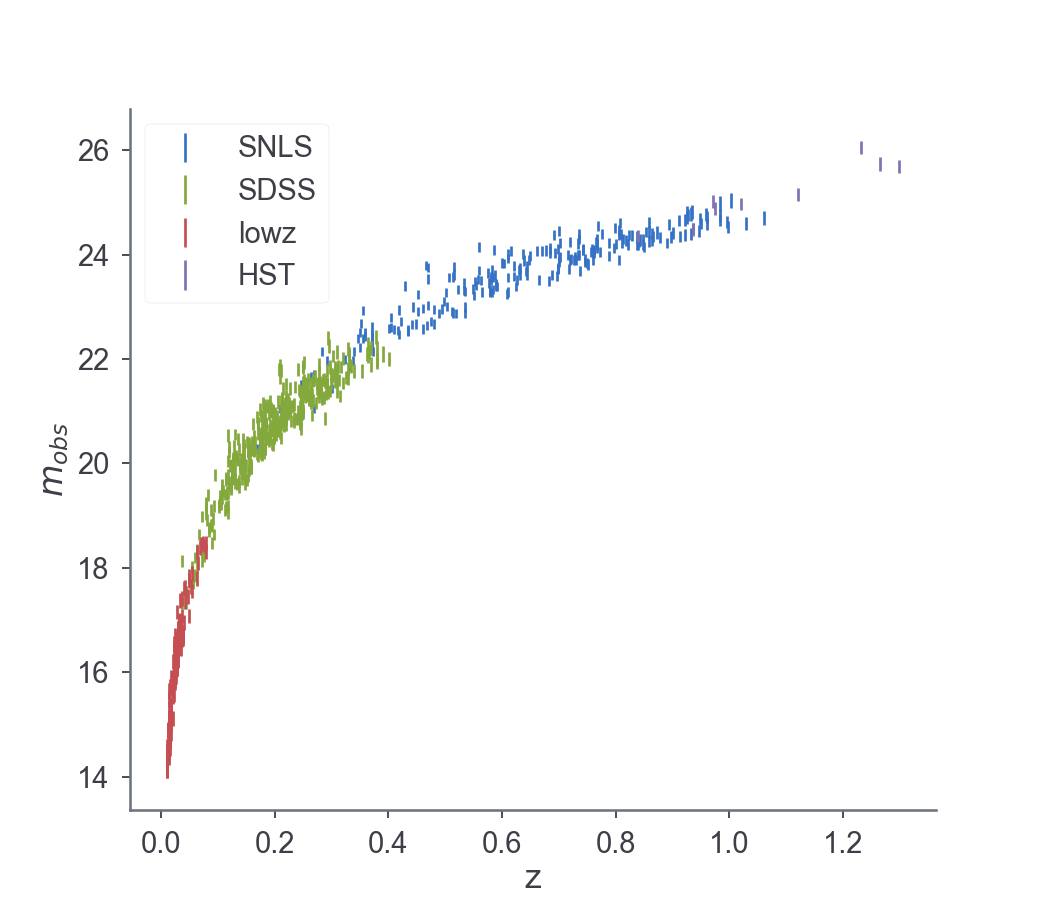

Text(0, 0.5, '$m_{obs}$')

In [23]:
fig, ax = plt.subplots()

for i,ds in enumerate([snls, sdss, lowz, hst]):
    
    ax.errorbar(jla_data_set.zcmb[ds], jla_data_set.mb[ds],  yerr=jla_data_set.dmb[ds], fmt='_', label=survery_names[i])
ax.legend()


ax.set_xlabel('z')
ax.set_ylabel(r'$m_{obs}$')
    

## What we measure and what we think

Assuming that every Sn has the same intrinsic B-band magnitude, $M_B$, the observed distance modulus, $\mu_B$ can can be computed using the measured apparent magnitude, $m_B$ via:

$$\mu_{\mathrm{obs}}=m_{B}-M_{B}$$

If we wanted to *predict* the distance modulus, $\mu_{C}$, at some redshift, $z$, we can compute it from cosmology such via: 

$$\mu_{C}=5 \log \left[\frac{d_{L}}{10 \mathrm{pc}}\right]$$

$$d_{L}=(1+z) \frac{c}{H_{0}} \int_{0}^{z} \frac{d z^{\prime}}{E\left(z^{\prime}\right)}$$

$$E(z)=\sqrt{\Omega_{m}\left(1+z^{\prime}\right)^{3}+\Omega_{k}\left(1+z^{\prime}\right)^{2}+\Omega_{\Lambda}\left(1+z^{\prime}\right)^{3(1+w)}}$$


<IPython.core.display.Javascript object>


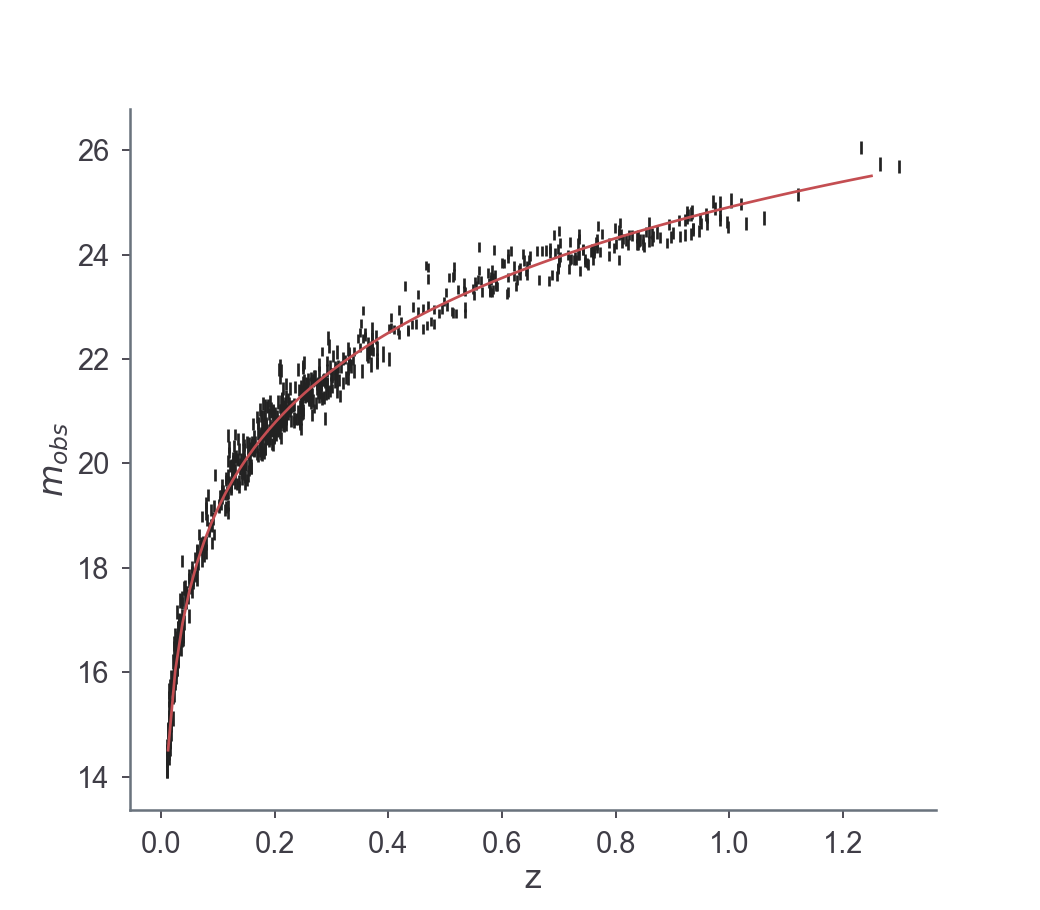

In [37]:
fig, ax = plt.subplots()

    
ax.errorbar(jla_data_set.zcmb, jla_data_set.mb,  yerr=jla_data_set.dmb, fmt='_',color='k')

ax.set_xlabel('z')
ax.set_ylabel(r'$m_{obs}$')


zgrid = np.linspace(0,1.25,100)

ax.plot(zgrid, cosmo.distmod(zgrid).value -19.25,color='r' )


# Fitting (the old way)

So it appears we can simply minimize the distance between $\mu_B$ and $\mu_C$. We can right the likelihood such that

$$\chi^{2}=\left(\mu_{\mathrm{obs}}-\mu_{C}\right)^{\dagger} C_{\mu}^{-1}\left(\mu_{\mathrm{obs}}-\mu_{C}\right)$$

where we can iterate the cosmological parameters to get as close a match as possible between data and prediction.

Let's examine this in Stan!

$$d \theta_{ \pm}=-\frac{c d_{\mp}(\delta T)}{D \sin \theta}$$


<IPython.core.display.Javascript object>


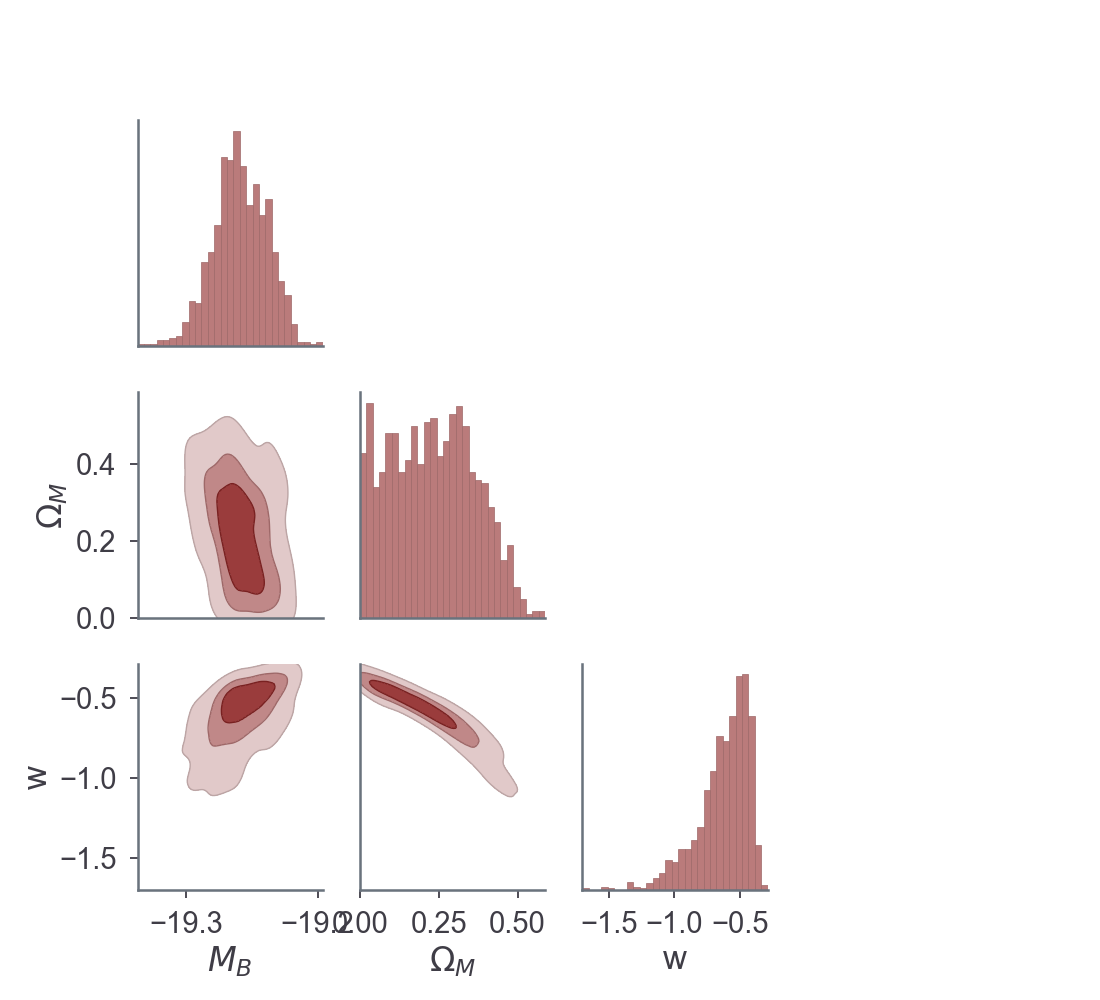

In [43]:
fit = stan_utility.StanSavedFit('sncosmo_simple_fit.h5')



fig = bayescorner( params = [fit.Om, fit.w, fit.M0 ],
            param_names=[r'$\Omega_M$', 'w',r'$M_B$'], figsize=(11,10))

<IPython.core.display.Javascript object>


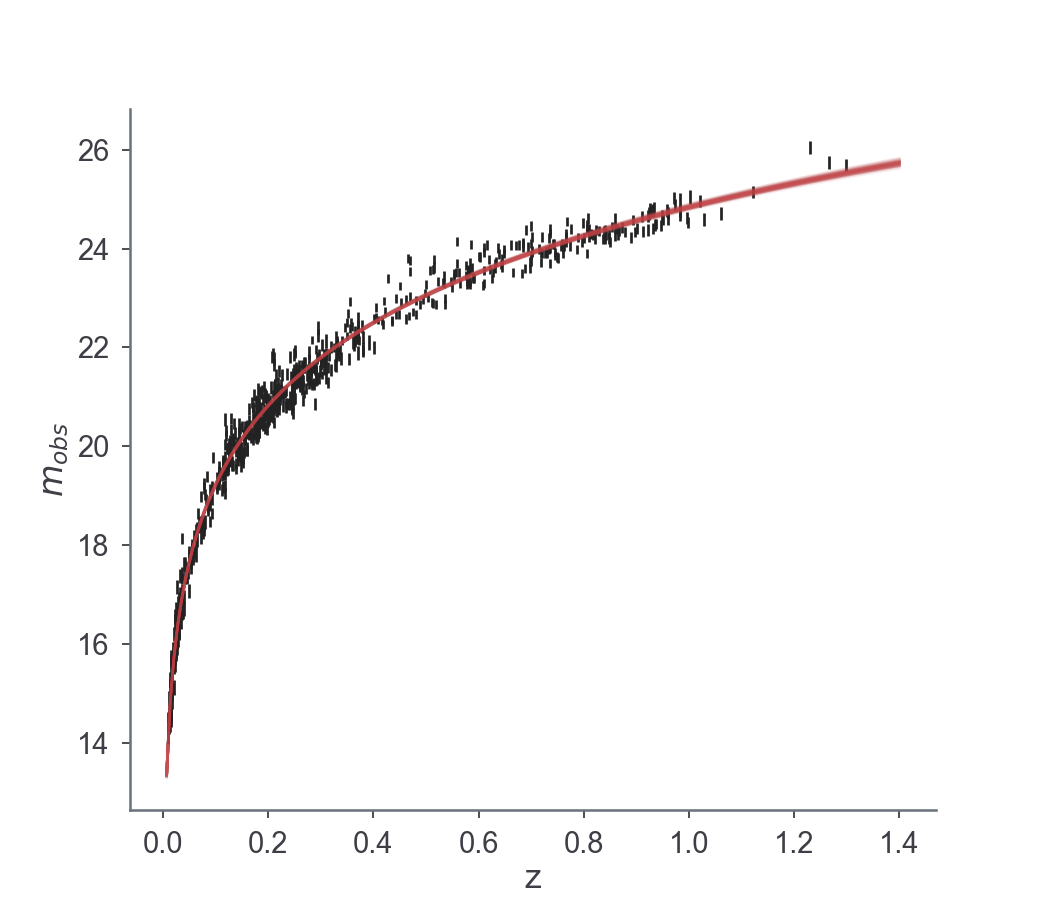

In [48]:
fig, ax = plt.subplots()

    
ax.errorbar(jla_data_set.zcmb, jla_data_set.mb,  yerr=jla_data_set.dmb, fmt='_',color='k')

ax.set_xlabel('z')
ax.set_ylabel(r'$m_{obs}$')


zgrid = np.linspace(0,1.25,100)

n_model = 200
z_model = np.linspace(0,1.4,n_model)

for mb in fit.mb_curve[::10]:
    ax.plot(z_model, mb,color='r', alpha = 0.05)



# The Philips Correction 

Very early on, astronomers realized that Sn were not perfect standard candles. Soon, they realized that corrections to the observed distance modulus were needed. This takes the form of the Philips correction:


$$\mu_{\mathrm{obs}}=m_{B}+\alpha x_{1}-\beta c-M_{B}$$

Now, $\alpha$ and $\beta$ are determined **during** the fit along with cosmology and are thus dependent on **the cosmological model from which they were determined!**


For now, we simply place uniform priors on $\alpha$ and $\beta$

Let's now throw this into Stan and see what we get. 






In [63]:
fit = stan_utility.StanSavedFit('sncosmo_bias_fit.h5')

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/h5py-2.9.0-py3.7-macosx-10.14-x86_64.egg/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


<IPython.core.display.Javascript object>


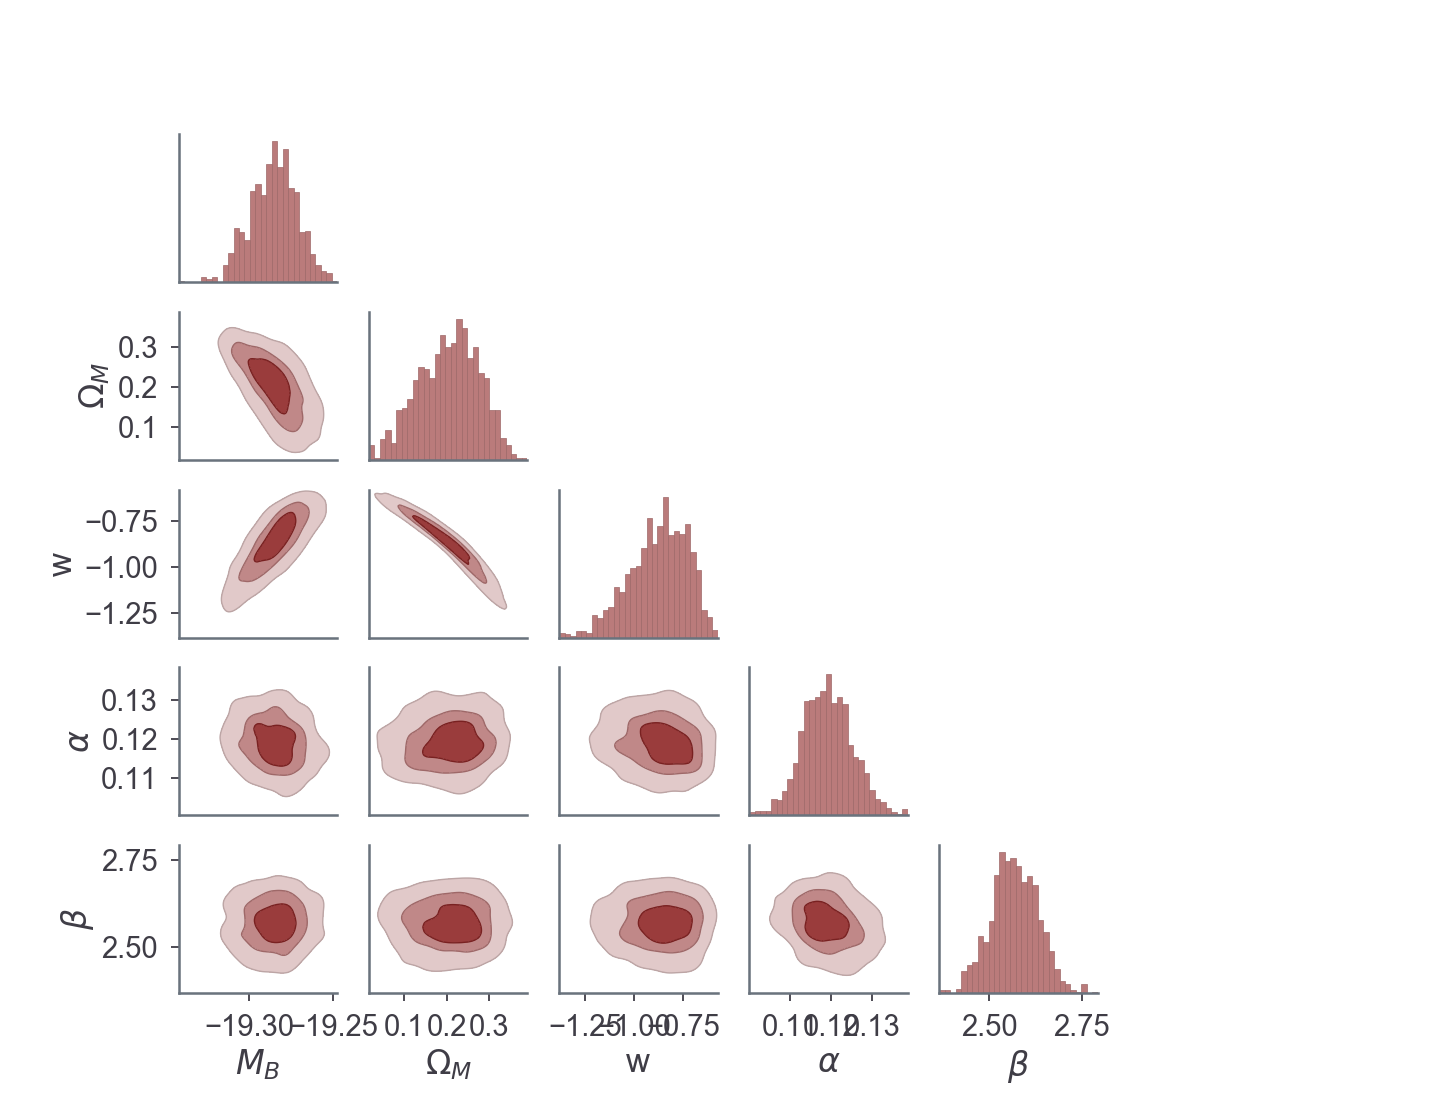

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


In [64]:
fig = bayescorner( params = [fit.Om, fit.w, fit.alpha, fit.beta, fit.M0],
            param_names=[r'$\Omega_M$', 'w', r'$\alpha$', r'$\beta$', r'$M_B$'], figsize=(11,9)

);



<IPython.core.display.Javascript object>


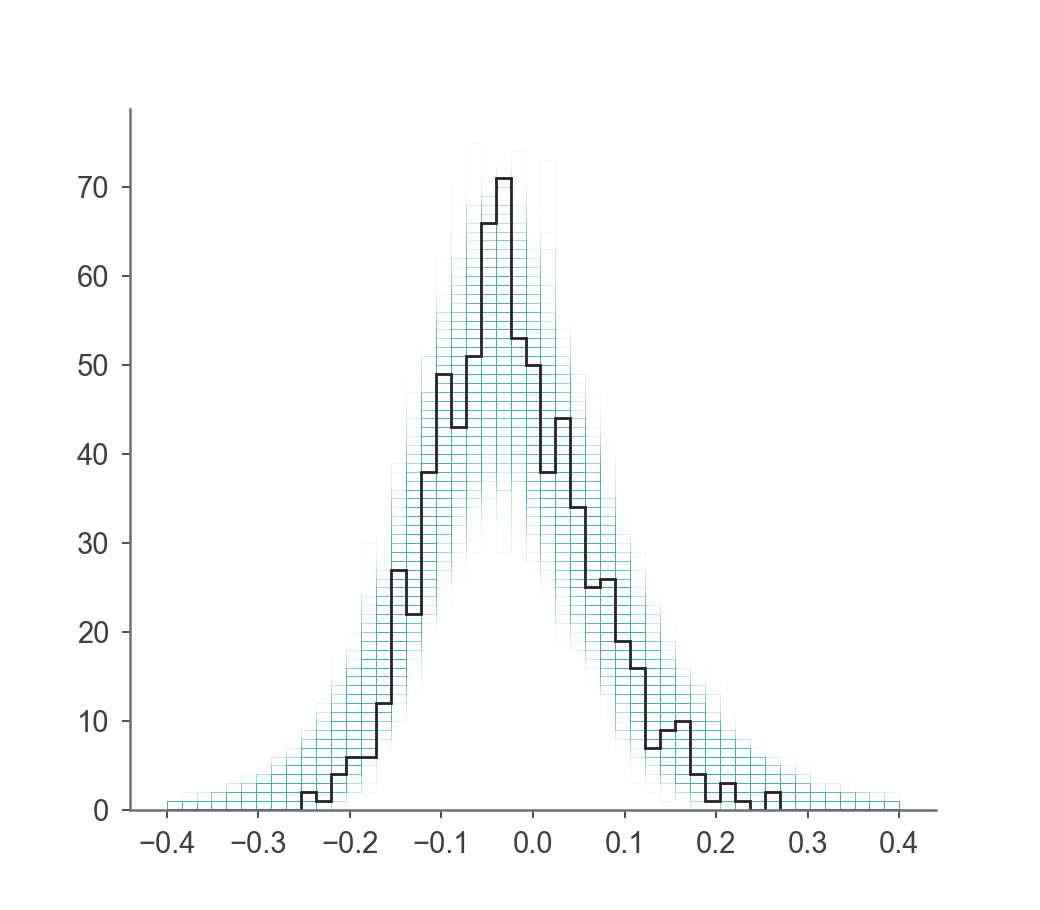

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  4.,  6.,
         6., 12., 27., 22., 38., 49., 43., 51., 66., 71., 53., 50., 38.,
        44., 34., 25., 26., 19., 16.,  7.,  9., 10.,  4.,  1.,  3.,  1.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-0.4       , -0.38367347, -0.36734694, -0.35102041, -0.33469388,
        -0.31836735, -0.30204082, -0.28571429, -0.26938776, -0.25306122,
        -0.23673469, -0.22040816, -0.20408163, -0.1877551 , -0.17142857,
        -0.15510204, -0.13877551, -0.12244898, -0.10612245, -0.08979592,
        -0.07346939, -0.05714286, -0.04081633, -0.0244898 , -0.00816327,
         0.00816327,  0.0244898 ,  0.04081633,  0.05714286,  0.07346939,
         0.08979592,  0.10612245,  0.12244898,  0.13877551,  0.15510204,
         0.17142857,  0.1877551 ,  0.20408163,  0.22040816,  0.23673469,
         0.25306122,  0.26938776,  0.28571429,  0.30204082,  0.31836735,
         0.33469388,  0.35102041,  0.36734694,  0.38367347,  0.4

In [70]:
bins = np.linspace(-0.4,0.4, 50)

fig, ax = plt.subplots()

for c in fit.c_obs_ppc[::1]:
    
    
    ax.hist(c,bins=bins,color=mid,alpha=0.05,histtype='step',lw=.7)
    
ax.hist(jla_data_set.color,bins=bins,color='k',histtype='step',lw=2)    

<IPython.core.display.Javascript object>


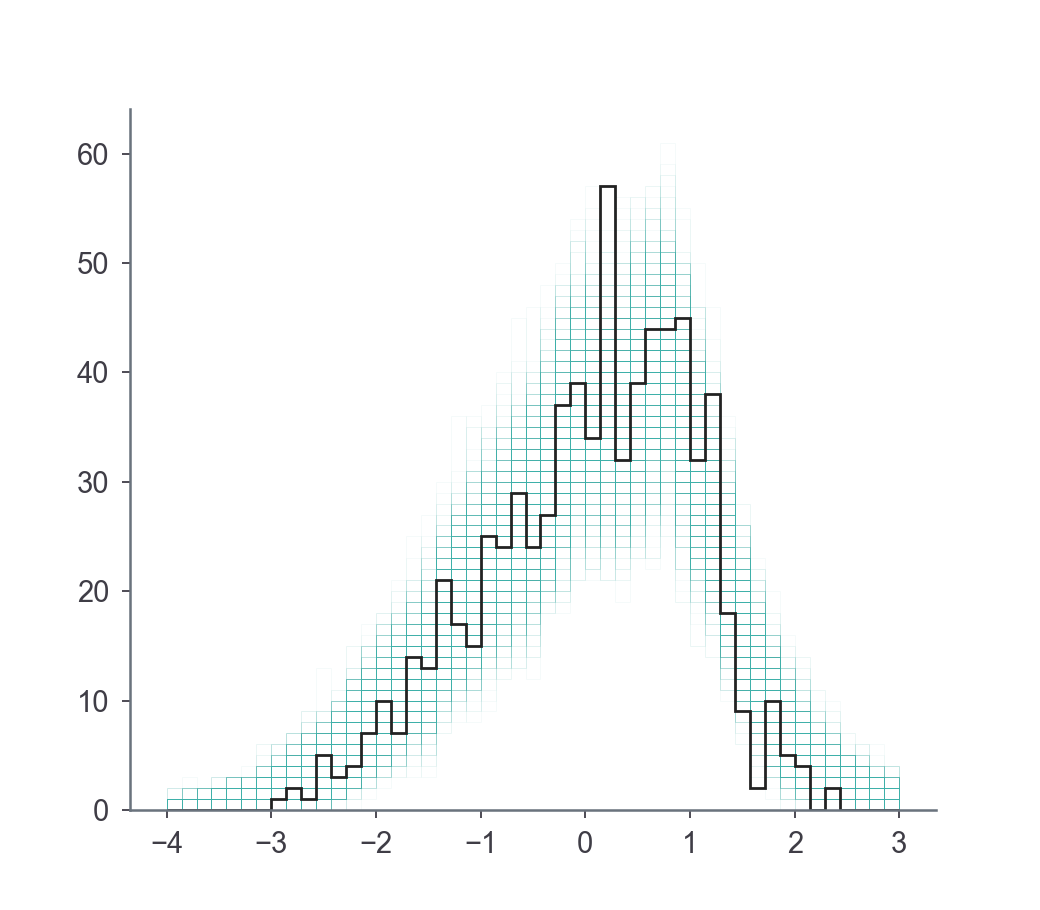

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  5.,  3.,  4.,
         7., 10.,  7., 14., 13., 21., 17., 15., 25., 24., 29., 24., 27.,
        37., 39., 34., 57., 32., 39., 44., 44., 45., 32., 38., 18.,  9.,
         2., 10.,  5.,  4.,  0.,  2.,  0.,  0.,  0.,  0.]),
 array([-4.        , -3.85714286, -3.71428571, -3.57142857, -3.42857143,
        -3.28571429, -3.14285714, -3.        , -2.85714286, -2.71428571,
        -2.57142857, -2.42857143, -2.28571429, -2.14285714, -2.        ,
        -1.85714286, -1.71428571, -1.57142857, -1.42857143, -1.28571429,
        -1.14285714, -1.        , -0.85714286, -0.71428571, -0.57142857,
        -0.42857143, -0.28571429, -0.14285714,  0.        ,  0.14285714,
         0.28571429,  0.42857143,  0.57142857,  0.71428571,  0.85714286,
         1.        ,  1.14285714,  1.28571429,  1.42857143,  1.57142857,
         1.71428571,  1.85714286,  2.        ,  2.14285714,  2.28571429,
         2.42857143,  2.57142857,  2.71428571,  2.85714286,  3. 

In [73]:
bins = np.linspace(-4,3, 50)

fig, ax = plt.subplots()

for c in fit.x1_obs_ppc[::1]:
    
    
    ax.hist(c,bins=bins,color=mid,alpha=0.05,histtype='step',lw=.7)
    
ax.hist(jla_data_set.x1,bins=bins,color='k',histtype='step',lw=2)    

<IPython.core.display.Javascript object>


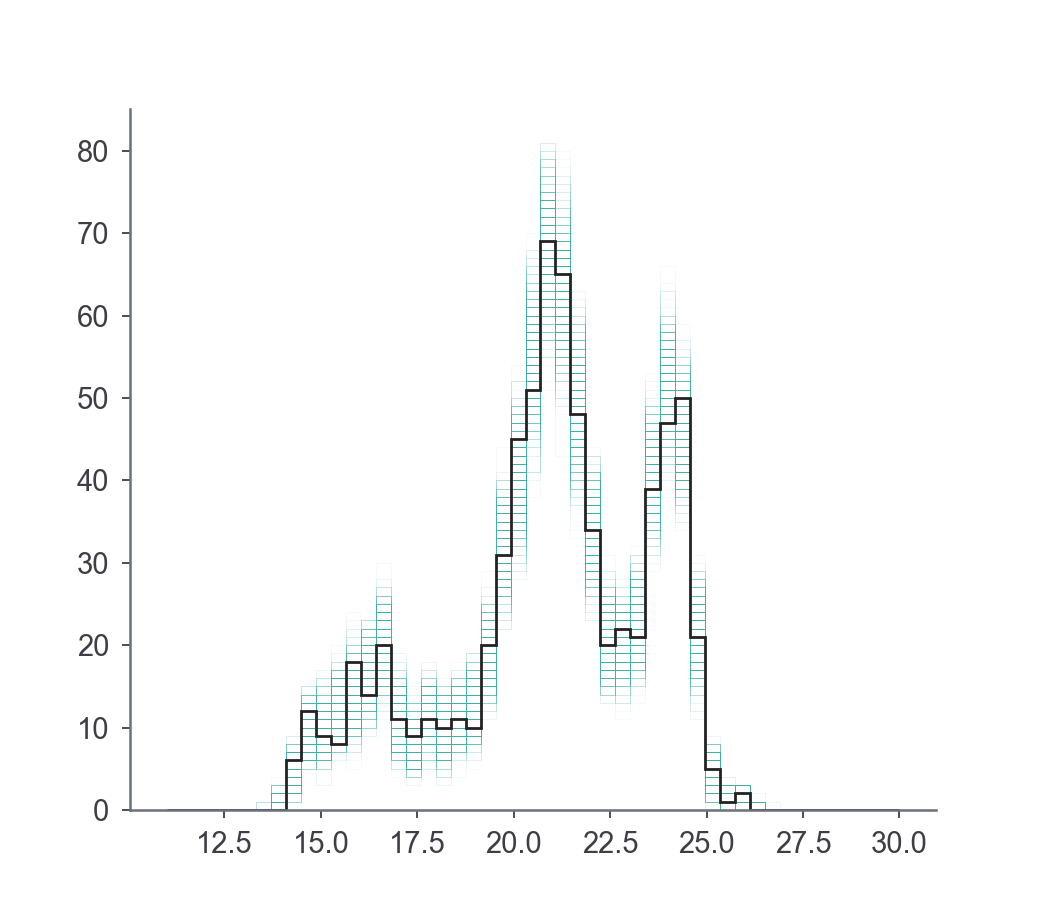

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 12.,  9.,  8., 18.,
        14., 20., 11.,  9., 11., 10., 11., 10., 20., 31., 45., 51., 69.,
        65., 48., 34., 20., 22., 21., 39., 47., 50., 21.,  5.,  1.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([11.        , 11.3877551 , 11.7755102 , 12.16326531, 12.55102041,
        12.93877551, 13.32653061, 13.71428571, 14.10204082, 14.48979592,
        14.87755102, 15.26530612, 15.65306122, 16.04081633, 16.42857143,
        16.81632653, 17.20408163, 17.59183673, 17.97959184, 18.36734694,
        18.75510204, 19.14285714, 19.53061224, 19.91836735, 20.30612245,
        20.69387755, 21.08163265, 21.46938776, 21.85714286, 22.24489796,
        22.63265306, 23.02040816, 23.40816327, 23.79591837, 24.18367347,
        24.57142857, 24.95918367, 25.34693878, 25.73469388, 26.12244898,
        26.51020408, 26.89795918, 27.28571429, 27.67346939, 28.06122449,
        28.44897959, 28.83673469, 29.2244898 , 29.6122449 , 30. 

In [74]:
bins = np.linspace(11,30, 50)

fig, ax = plt.subplots()

for c in fit.m_obs_ppc[::1]:
    
    
    ax.hist(c,bins=bins,color=mid,alpha=0.05,histtype='step',lw=.7)
    
ax.hist(jla_data_set.mb,bins=bins,color='k',histtype='step',lw=2)    

# The (almost) right way

It seems we have a better fit more inline with what we expect. But we haven't discussed selection effects or bias.

Let's have a look at the color and stretch parameters ranked by the size of their errors.

<IPython.core.display.Javascript object>


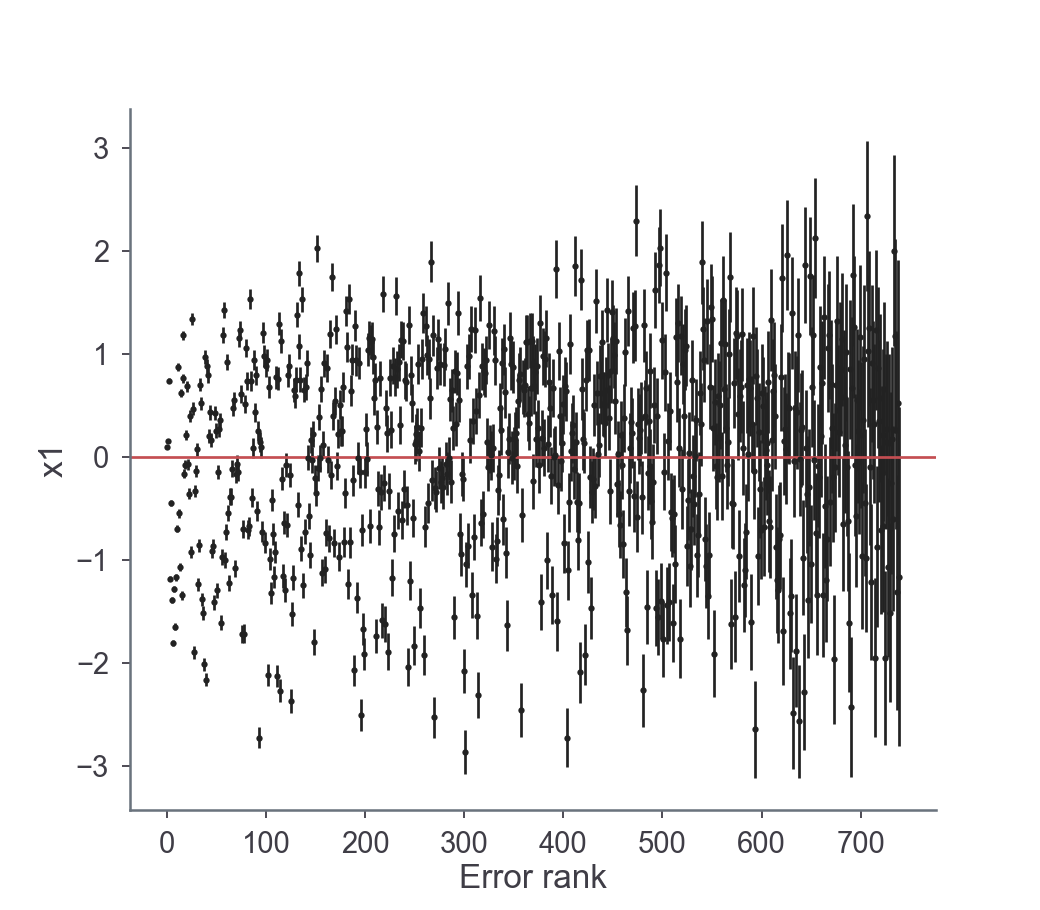

<IPython.core.display.Javascript object>


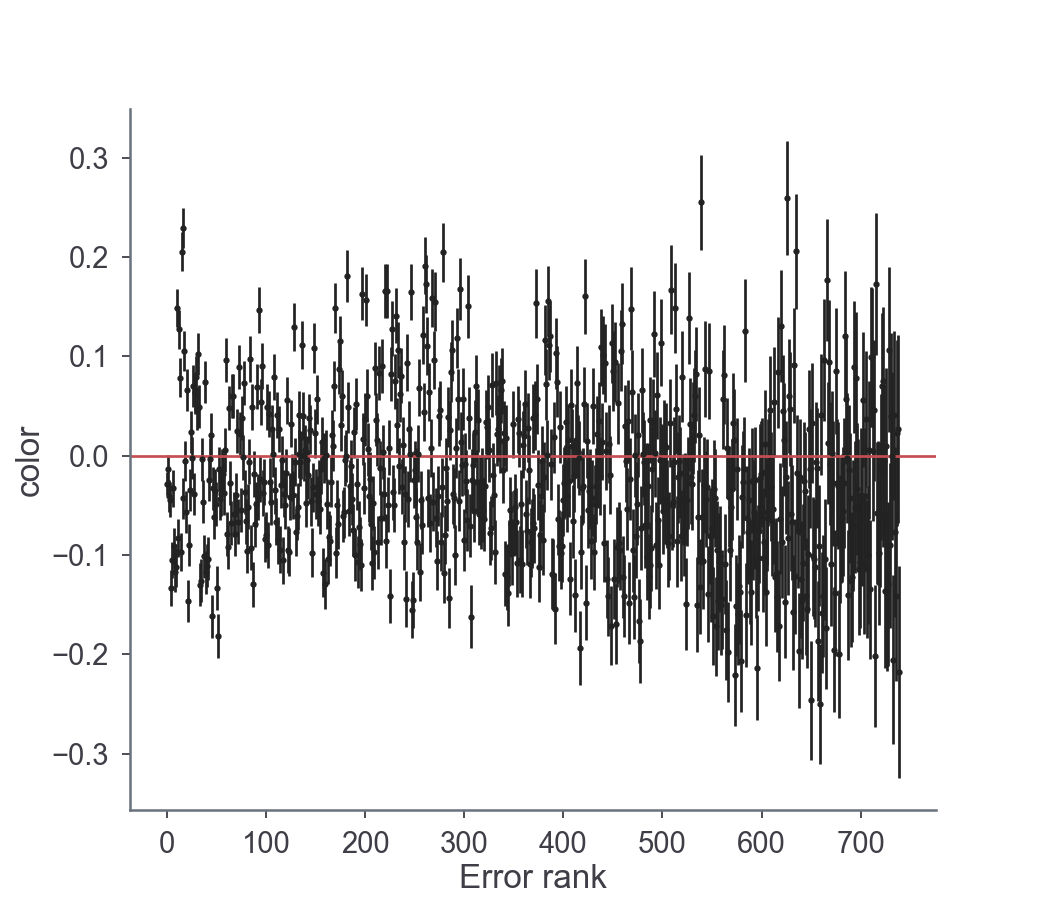

Text(0.5, 0, 'Error rank')

In [51]:
sort_idx = np.argsort(np.array(jla_data_set.dx1))

fig, ax = plt.subplots()


#ax.scatter(, np.array(jla_data_set.dx1)[sort_idx] )

ax.errorbar(range(len(sort_idx)), jla_data_set.x1[sort_idx], yerr=jla_data_set.dx1[sort_idx], fmt='.', color='k' )
ax.axhline(0,color='r')





sort_idx = np.argsort(np.array(jla_data_set.dcolor))

ax.set_ylabel('x1')
ax.set_xlabel('Error rank')





sort_idx = np.argsort(np.array(jla_data_set.dcolor))

fig, ax = plt.subplots()


#ax.scatter(, np.array(jla_data_set.dx1)[sort_idx] )

ax.errorbar(range(len(sort_idx)), jla_data_set.color[sort_idx], yerr=jla_data_set.dcolor[sort_idx], fmt='.' , color='k')
ax.axhline(0,color='r')

ax.set_ylabel('color')
ax.set_xlabel('Error rank')


## Malmquist Bias

This is an example of Malmquist-like bias,  i.e., the data scatter more than their error bars. We can fits this by assuming that the parameters come from the same hyper-distribution. 

$$c_{true} \sim \mathcal{N}(\mu_c, \tau_c)$$
$$x1_{true} \sim \mathcal{N}(\mu_{x1}, \tau_{x1})$$


Thus, the color and stretch parameters "learn" what they should be from the other Sne. This is a form of hierarchical model. We allow the mean and std of the hyper-distributions to be free parameters during the fit. 


In [52]:
fit = stan_utility.StanSavedFit('sncosmo_fit.h5')

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/h5py-2.9.0-py3.7-macosx-10.14-x86_64.egg/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


<IPython.core.display.Javascript object>


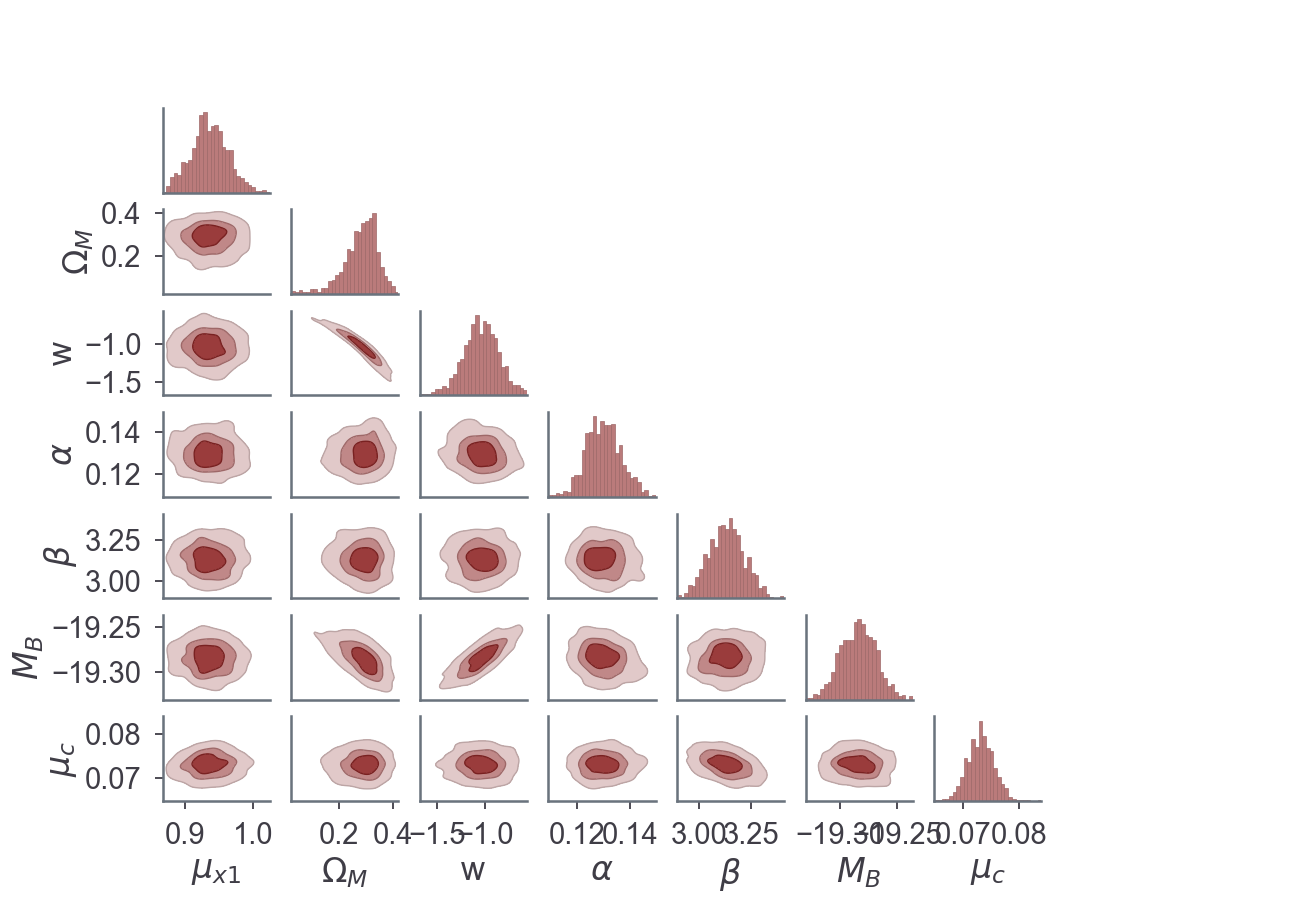

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


In [54]:
fig = bayescorner( params = [fit.Om, fit.w, fit.alpha, fit.beta, fit.M0, fit.Rc, fit.Rx],
            param_names=[r'$\Omega_M$', 'w', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\mu_c$', r'$\mu_{x1}$'], figsize=(11,9)

);



<IPython.core.display.Javascript object>


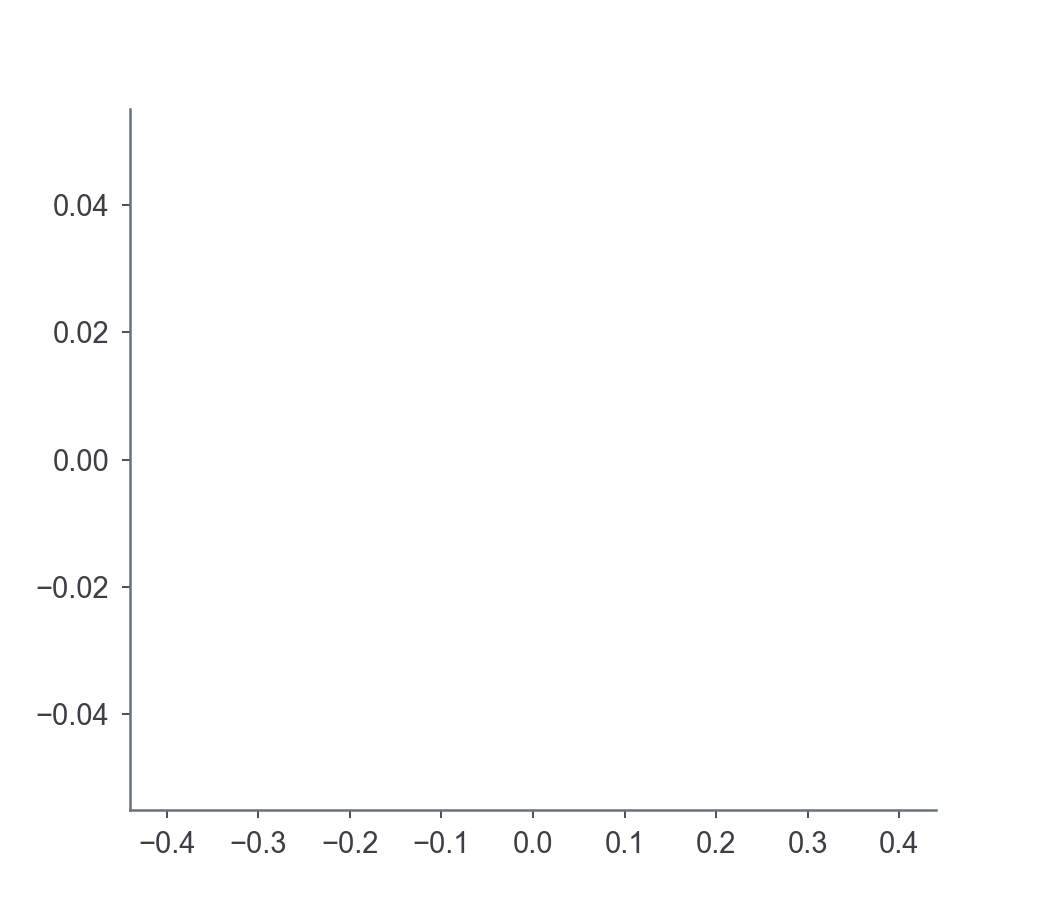

In [57]:
bins = np.linspace(-0.4,0.4, 50)

fig, ax = plt.subplots()

for c in fit.c_obs_ppc[::20]:
    
    
    ax.hist(c,bins=bins,color=mid,alpha=0.05)
    
    
    
    

In [62]:
 fit.m_obs_ppc

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])